This notebook loads the comparison between sleep optimization and elbo-optimization in Section 5 of our paper. 

The fits to produce these results have been pre-saved in the `../fits/` directory. 

In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import deblending_runjingdev.starnet_lib as starnet_lib

from deblending_runjingdev.which_device import device

In [2]:
np.random.seed(5759)
_ = torch.manual_seed(1345)

# Get image

In [3]:
test_image_file = '../test_image_20x20.npz'
full_image = torch.Tensor(np.load(test_image_file)['image']).unsqueeze(0).to(device)

slen = full_image.shape[-1]

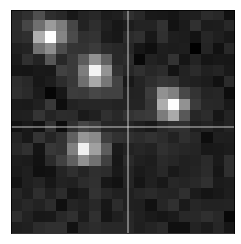

In [4]:
plt.matshow(full_image.cpu()[0, 0], 
            cmap=plt.cm.gray)

plt.axhline(10, color = 'white', alpha = 0.5)
plt.axvline(10, color = 'white', alpha = 0.5)

plt.yticks([])
plt.xticks([]);

# Optimization trace plots

In [5]:
def plot_optimization_trace(fit_files, ax): 
    for f in fit_files: 
        
        # load elbo results
        elbo_results = np.loadtxt(f + '-elbo_results')
        
        # wall time  against elbo
        time_vec = elbo_results[:, -1]
        elbo_vec = elbo_results[:, 0]
        
        ax.plot(time_vec - time_vec[0], 
                elbo_vec, 
                linestyle = '-')

In [6]:
fit_dir = '../fits/'

# reinforce fits
reinforce_fit_files = [fit_dir + 'starnet_encoder_reinforce-restart' + \
                       str(i) for i in range(1, 7)]


# reparameterization files
reparam_fit_files = [fit_dir + 'starnet_encoder_allsum-restart' + \
                       str(i) for i in range(1, 7)]

# sleep encoder files
sleep_fit_files = [fit_dir + 'starnet_klpq-restart' + \
                       str(i) for i in range(1, 7)]


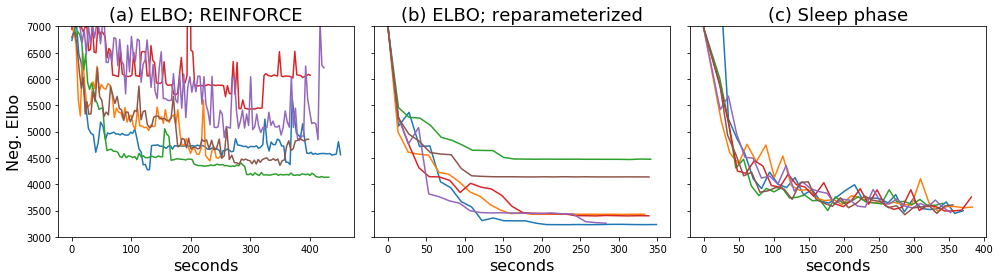

In [7]:
fig, axarr = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

plot_optimization_trace(reinforce_fit_files, axarr[0])
plot_optimization_trace(reparam_fit_files, axarr[1])
plot_optimization_trace(sleep_fit_files, axarr[2])


for i in range(3): 
    axarr[i].set_ylim(3e3, 7e3)
    axarr[i].set_xlabel('seconds', fontsize = 16)

axarr[0].set_ylabel('Neg. Elbo', fontsize = 16)


axarr[0].set_title('(a) ELBO; REINFORCE', fontsize = 18); 
axarr[1].set_title('(b) ELBO; reparameterized', fontsize = 18); 
axarr[2].set_title('(c) Sleep phase', fontsize = 18); 

fig.tight_layout()

fig.savefig('../../figures/elbo_vs_sleep/optim_path_compare.png')

# Plot detections

### pick an elbo-optimized encoder that landed in a local optimum

In [8]:
elbo_encoder = starnet_lib.StarEncoder(slen = 20,
                                       ptile_slen = 10,
                                       step = 10,
                                       edge_padding = 0,
                                       n_bands = 2,
                                       max_detections = 2, 
                                       track_running_stats=False)

elbo_encoder.load_state_dict(torch.load(fit_dir + 'starnet_encoder_allsum-restart3',
                               map_location=lambda storage, loc: storage))
elbo_encoder.to(device);
elbo_encoder.eval(); 

### Load any sleep-optimized encoder

In [9]:
sleep_encoder = starnet_lib.StarEncoder(slen = 20,
                                       ptile_slen = 10,
                                       step = 10,
                                       edge_padding = 0,
                                       n_bands = 2,
                                       max_detections = 2)

sleep_encoder.load_state_dict(torch.load(fit_dir + 'starnet_klpq-restart1',
                               map_location=lambda storage, loc: storage))
sleep_encoder.to(device);
sleep_encoder.eval(); 

In [10]:
def plot_detections(star_encoder, ax): 
    map_locs = star_encoder.sample_star_encoder(full_image, 
                                                 return_map_n_stars = True,
                                                 return_map_star_params = True,
                                                 n_samples = 1)[0]
        
    # plot detections
    ax.scatter(map_locs[0, :, 1].cpu() * (slen - 1), 
                     map_locs[0, :, 0].cpu() * (slen - 1), 
                     color = 'red',
                     marker = 'x', 
                     label = 'Est.')

In [11]:
true_locs = np.load(test_image_file)['locs']

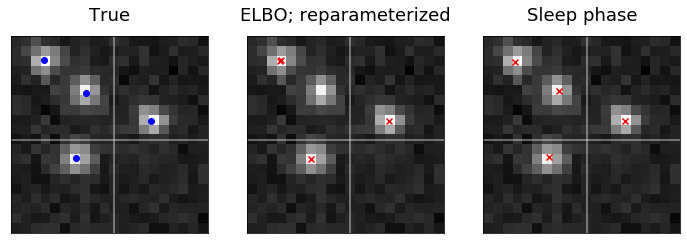

In [12]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# plot image
for i in range(3): 
    axarr[i].matshow(full_image.cpu()[0, 0], cmap=plt.cm.gray)
    axarr[i].set_yticks([])
    axarr[i].set_xticks([])

# plot truth 
axarr[0].scatter(true_locs[:, 1] * (slen - 1), 
                 true_locs[:, 0] * (slen - 1), 
                 color = 'blue',
                 marker = 'o', 
                 label = 'Est.')
    
# plot detections
plot_detections(elbo_encoder, axarr[1])
plot_detections(sleep_encoder, axarr[2])

# labels
axarr[0].set_title('True', fontsize = 18)
axarr[1].set_title('ELBO; reparameterized', fontsize = 18)
axarr[2].set_title('Sleep phase', fontsize = 18)

# plot tiles
for i in range(3): 
    axarr[i].axhline(10, color = 'white', alpha = 0.5)
    axarr[i].axvline(10, color = 'white', alpha = 0.5)

fig.savefig('../../figures/elbo_vs_sleep/optim_path_detect_compare.png')